In [0]:
import numpy as np
X= np.load('/content/drive/My Drive/X.npy')
Y= np.load('/content/drive/My Drive/Y.npy')

In [0]:
X.shape

(2160, 64, 3518)

In [0]:
#Recurrence plots code start

from pyts.multivariate.image import JointRecurrencePlot
from scipy import signal

rp = JointRecurrencePlot(threshold='distance', percentage=50)


In [0]:
def preprocess(series):
    # original_Fs=3518
    # F = int((original_Fs * 1) / downsample_to)
    d_series = signal.resample_poly(series, up=1, down=6)
    d_series = np.reshape(d_series, (1,d_series.shape[0]))
    return d_series

In [0]:
def extract(arr):
  data = preprocess(arr[0,:])
  # print(arr[0,:].shape)
  for i in range(1,64):
    data = np.concatenate((data, preprocess(arr[i,:])), axis=0)
  # print(data.shape)
  return data

In [0]:
X_final = np.zeros((2160,64,587))
for i in range(X.shape[0]):
  h=extract(X[i])
  X_final[i] = h

In [0]:
X_image= np.zeros((2160,587,587))
for i in range(X.shape[0]):
    m=np.reshape(X_final[i],(1,X_final.shape[1],X_final.shape[2]))
    X_image[i] = rp.transform(m)

In [0]:
X_image.shape

(2160, 587, 587)

In [0]:
import matplotlib.pyplot as plt

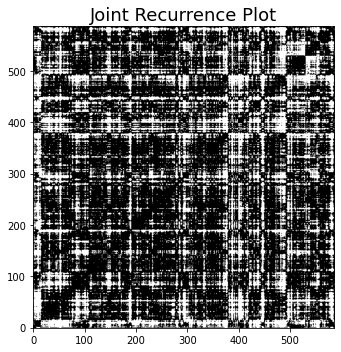

In [0]:
plt.figure(figsize=(5, 5))
plt.imshow(X_image[2159], cmap='binary', origin='lower')
plt.title('Joint Recurrence Plot', fontsize=18)
plt.tight_layout()
plt.show()

In [0]:
x_train=X_image[:1680]
y_train=Y[:1680]
x_valid=X_image[1680:1920]
y_valid=Y[1680:1920]
x_test=X_image[1920:]
y_test=Y[1920:]
print(x_train.shape,y_train.shape, x_valid.shape, y_valid.shape, x_test.shape, y_test.shape)

(1680, 587, 587) (1680,) (240, 587, 587) (240,) (240, 587, 587) (240,)


In [0]:
w, h = 587, 587
x_train = x_train.reshape(x_train.shape[0], w, h, 1)
x_valid = x_valid.reshape(x_valid.shape[0], w, h, 1)
x_test = x_test.reshape(x_test.shape[0], w, h, 1)

In [0]:
print(x_train.shape,y_train.shape, x_valid.shape, y_valid.shape, x_test.shape, y_test.shape)

(1680, 587, 587, 1) (1680,) (240, 587, 587, 1) (240,) (240, 587, 587, 1) (240,)


In [0]:
import tensorflow as tf
np.random.seed(69)

model = tf.keras.Sequential()

# Must define the input shape in the first layer of the neural network
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu', input_shape=(587,587,1))) 
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
# model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=2, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
# model.add(tf.keras.layers.Dropout(0.3))
# model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=2, padding='same', activation='relu'))
# model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(98, activation='relu'))
# model.add(tf.keras.layers.Dense(50, activation='relu'))
# model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(12, activation='softmax'))

# Take a look at the model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 587, 587, 32)      160       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 293, 293, 32)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 293, 293, 16)      2064      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 146, 146, 16)      0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 341056)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 98)                33423586  
_________________________________________________________________
dense_7 (Dense)              (None, 12)               

In [0]:
from tensorflow.keras import optimizers
opt = optimizers.Adam(lr=0.0001)
model.compile(loss='sparse_categorical_crossentropy',
             optimizer=opt,
             metrics=['accuracy'])

In [0]:
from tensorflow.keras.callbacks import ModelCheckpoint

mc = ModelCheckpoint('/content/drive/My Drive/Data/weights{epoch:08d}.h5', save_weights_only=True, period=1)
# checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose = 1, save_best_only=True)
model.fit(x_train,
         y_train,
         batch_size=10,
         epochs=15,
         validation_data=(x_valid, y_valid),
         callbacks=[mc])

Epoch 1/15
168/168 [==============================] - 23s 138ms/step - loss: 2.5894 - accuracy: 0.0857 - val_loss: 2.4849 - val_accuracy: 0.0833
Epoch 2/15
168/168 [==============================] - 23s 136ms/step - loss: 2.4849 - accuracy: 0.0768 - val_loss: 2.4849 - val_accuracy: 0.0833
Epoch 3/15
168/168 [==============================] - 23s 136ms/step - loss: 2.4850 - accuracy: 0.0720 - val_loss: 2.4849 - val_accuracy: 0.0833
Epoch 4/15
 29/168 [====>.........................] - ETA: 16s - loss: 2.4850 - accuracy: 0.0931

KeyboardInterrupt: ignored

In [0]:
# Load the weights with the best validation accuracy
model.load_weights('/content/drive/My Drive/weights00000010.h5')
# model.load_weights('model.weights.best.hdf5')

In [0]:
# Evaluate the model on test set
score = model.evaluate(x_test, y_test, verbose=0)

# Print test accuracy
print('\n', 'Test accuracy:', score)


 Test accuracy: [2.720365047454834, 0.11249999701976776]


In [0]:
yhat=model.predict(x_test)

In [0]:
yhat.shape

(240,)

In [0]:
y_test.shape

(240,)

In [0]:
cm = np.zeros((12,12), dtype=int)
np.add.at(cm, [y_test, yhat], 1)
cm

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


array([[15,  0,  0,  0,  5,  0,  0,  0,  0,  0,  0,  0],
       [18,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0],
       [13,  1,  0,  0,  6,  0,  0,  0,  0,  0,  0,  0],
       [17,  0,  0,  0,  1,  0,  1,  0,  0,  1,  0,  0],
       [14,  0,  0,  0,  6,  0,  0,  0,  0,  0,  0,  0],
       [17,  0,  0,  0,  3,  0,  0,  0,  0,  0,  0,  0],
       [16,  0,  0,  0,  4,  0,  0,  0,  0,  0,  0,  0],
       [16,  0,  0,  0,  4,  0,  0,  0,  0,  0,  0,  0],
       [15,  0,  0,  0,  4,  0,  1,  0,  0,  0,  0,  0],
       [11,  0,  0,  0,  8,  0,  1,  0,  0,  0,  0,  0],
       [16,  0,  0,  0,  3,  0,  1,  0,  0,  0,  0,  0],
       [18,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0]])